# Advanced Data Analytics for Management Support - Assignment Submission

## by Sinan Wang

# Table of Contents

    1. Introduction
    2. Data preparation and EDA
        2.1 Loading data
        2.2 Textual feature preparation and EDA
        2.3 Numerical feature preparation and EDA
        2.4 Categorical feature preparation and EDA
        2.5 Splitting data
    3. Feature Engineering
        3.1 Textual feature engineer
        3.2 Numerical feature engineer
        3.3 Categorical feature engineer
        3.4 Final tabular dataframe combination
    4. Model Selection
        4.1 Random Forest
        4.2 Feedforward NN
        4.3 RNN Architecture
        4.4 CNN Architecture
        4.5 Model Performance Summary
    5. Application to Test Set
    6. Conclusion

# 1.Introduction

The task of this assignment is to predict the property prices for Airbnb listings in london. As we know, Airbnb is a long term renting platment where hosts can list their proporties and determine the rental price themselves.  

In the following, we will solve the task by using both the tabular data and text data. The basic pipeline involves: data preparation and EDA, feature engineer, building model and model evaluation. The best model will be applied to the test data at last. 

At the very beginning, we will import all the necessary libraries.

In [1]:
#import all necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from statsmodels.formula.api import ols
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import tensorflow as tf
import string
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.preprocessing.text import Tokenizer
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow import keras
from tensorflow.keras import layers
import os  
from keras.layers import GRU
from tensorflow.keras.layers import Input, Embedding, Dense, Dropout, SpatialDropout1D
from tensorflow.keras.layers import concatenate, GlobalAveragePooling1D, GlobalMaxPooling1D
from tensorflow.keras.models import Model
import tensorflow_text
from sklearn.model_selection import GridSearchCV
import time
from keras.callbacks import EarlyStopping
from gensim.models import KeyedVectors
from gensim.models.keyedvectors import Word2VecKeyedVectors
from keras.initializers import Constant
import math

# 2.Data Preparation and EDA

In section 2, we will load the data and inspect the features by categories, namely textual features, numerical features and categorical features. 

As to textual feature, the basic data cleaning pipeline involves: dealing with null/missing value, preprocessing the text data and EDA. As to numerical variables, we extract three numerical features from 'amenities' and 'descripton' and also deal with the null/missing value, EDA and perform feature selection. As to categorical variables, we will deal with the null/missing value, EDA and perform feature selection. At last, the training data will be splitted into train and validation dataset. 

## 2.1 Loading data

In [2]:
# import training set
df = pd.read_csv("train.csv.zip", sep=",")

# import test set
x_test =pd.read_csv("test.csv.zip", sep=",")

print("train dataset dimensinality:", df.shape, end='\n\n')
print("test dataset dimensinality:", x_test.shape, end='\n\n')


train dataset dimensinality: (55284, 42)

test dataset dimensinality: (29769, 41)



In [3]:
df.columns

Index(['name', 'summary', 'space', 'description', 'experiences_offered',
       'neighborhood_overview', 'transit', 'house_rules', 'picture_url',
       'host_id', 'host_since', 'host_response_time', 'host_response_rate',
       'host_is_superhost', 'host_total_listings_count',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'zipcode', 'latitude', 'longitude',
       'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms',
       'beds', 'bed_type', 'amenities', 'price', 'guests_included',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'cancellation_policy', 'reviews_per_month',
       'listing_id'],
      dtype='object')

In [4]:
x_test.columns

Index(['name', 'summary', 'space', 'description', 'experiences_offered',
       'neighborhood_overview', 'transit', 'house_rules', 'picture_url',
       'host_id', 'host_since', 'host_response_time', 'host_response_rate',
       'host_is_superhost', 'host_total_listings_count',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'zipcode', 'latitude', 'longitude',
       'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms',
       'beds', 'bed_type', 'amenities', 'guests_included',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'cancellation_policy', 'reviews_per_month',
       'listing_id'],
      dtype='object')

## 2.2 Textual feature preparation and EDA

As to textual feature, the basic data cleaning pipeline involves: dealing with null/missing value, selecting feature, preprocessing the text data and EDA.

### Deal with text null value

After checking the null value in textual features, we will replace the missing text with ''.

At first, we select the textual feature from all the features and deal with the missing value.

There are several approaches to deal with the missing text. One could be discarding the observations with missing text. Another approach is replacing missing text with empty string(''). There are still other valuable features in the observations with missing text and we donot want to lose the information of these observations. Therefore, we will replace the missing text with empty string('') instead of discarding the observation.

In [5]:
col_info ={}
col_info['text_cols']=[
    'summary','description','space',
    'neighborhood_overview','name','amenities'
]

In [6]:
print(df[col_info['text_cols']].isnull().sum())
print(x_test[col_info['text_cols']].isnull().sum())

summary                   2954
description               1726
space                    16881
neighborhood_overview    19506
name                        14
amenities                    0
dtype: int64
summary                   1577
description                943
space                     9057
neighborhood_overview    10551
name                        10
amenities                    0
dtype: int64


We noticed that there are many missing values in the textual features, such as 'space', 'neighborhood_overview'. Therefore, we may not use it to predict. 

The information in 'summary' and 'description' is quite similar. But there is less missing value in 'description' and 'description' is more detailed than 'summary', and thus we will use 'description' instead of 'summary'. 

We will also treat 'amenities' as textual feature, because we believe 'amenities' contains important information and there are more than 60 different levels of amenities. Therefore, it is unrealistic to treat 'amenities' as categorical feature. We will use 'amenities' as textual feature and preprocess it.

In [7]:
#replace empty cells with ''
for col_name in col_info['text_cols']:
    
    num_df = df[col_name]
    
    num_df = num_df.fillna('')
    col_values = num_df.values.reshape(-1,1)
    
    df[col_name]=col_values

In [8]:
#replace empty cells with ''
for col_name in col_info['text_cols']:
    
    num_df = x_test[col_name]
    
    num_df = num_df.fillna('')
    col_values = num_df.values.reshape(-1,1)
    
    x_test[col_name]=col_values

### Preprocess text data

Here is the step to preprocess the textual data.

The following steps are performed:

1. remove HTTP links
2. replace non English character with ' '
3. lower the text
4. remove stop words in English
5. remove punctuation
6. remove digits
7. remove unnecessary spaces
8. lemmatize the word and remove the lemmatized word with length less than 3

As we know, stemming is a process to reduce the word to its root but it also cause problems by stemming unwanted words. Instead, lematization has an advantage in dealing with the problem. Because lemmatization is a systematic way to reduce the words into their lemma by matching them with a language dictionary. Here we use 'Wordnetlemmatizer' from nltk to do lemmatize.

In [10]:
stop = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    """
    Main text cleaning function.
    """
    #remove the links
    text = re.sub('[^ ]+\.[^ ]+', "", text)
    #remove non english character
    text = re.sub('[^a-zA-Z]', ' ',text)
    #lower the text
    text = text.lower()
    #remove stop words
    text= " ".join([word for word in str(text).split() if word not in stop])
    #remove punctuation
    text =re.sub(r'[^\w\s]', '', text)
    #remove digits
    text = re.sub(r'\d+', " ", text)
    #remove unnecessary spaces
    text = re.sub(' +', " ", text)
    #Lemmatization and delete length less than 3
    text = " ".join([lemmatizer.lemmatize(word) for word in text.split() if len(lemmatizer.lemmatize(word)) >2])   
    return text

In [11]:
#example for preprocessing
preprocess('rooms are tidy,running中国, https://www.postgresql.org/docs/13/functions-formatting.html, 22,  2cd, GOOD!')

'room tidy running good'

In [12]:
df['amenitiesclean'] = df.amenities.apply(preprocess)

x_test['amenitiesclean'] = x_test.amenities.apply(preprocess)


In [13]:
df['desclean'] = df.description.apply(preprocess)

x_test['desclean'] = x_test.description.apply(preprocess)

### Text feature EDA

Here we can obtain an understanding of top 20 the most frequently used words in the text.

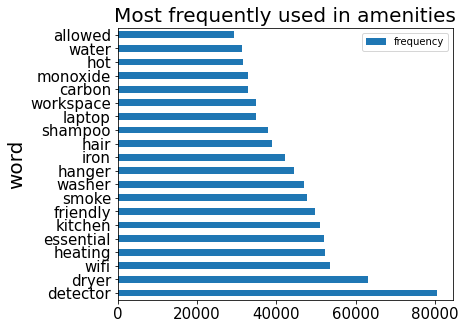

In [14]:
fre_ame =Counter(" ".join(df.amenitiesclean).split()).most_common(20)
plt.rcParams["figure.figsize"] = (6,5)
parameters = {'xtick.labelsize': 15,
          'ytick.labelsize': 15}
plt.rcParams.update(parameters)
a = pd.DataFrame(fre_ame, columns=['word', 'frequency']).set_index('word')
a.plot.barh()
plt.ylabel('word', fontsize=20)
plt.title("Most frequently used in amenities", fontsize=20)
plt.show()

From the figure, the most frequently appeared word is 'detector'(almost 80000 times), because there are smoke detector and carbon monoxide detector in 'amenities'. Dry, wifi, heating and kitchen are also frequently appeared words in 'amenities'.

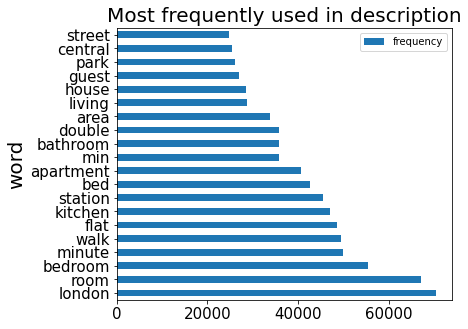

In [15]:
fre_des =Counter(" ".join(df['desclean']).split()).most_common(20)
plt.rcParams["figure.figsize"] = (6,5)
parameters = {'xtick.labelsize': 15,
          'ytick.labelsize': 15}
plt.rcParams.update(parameters)
x = pd.DataFrame(fre_des, columns=['word', 'frequency']).set_index('word')
x.plot.barh()
plt.ylabel('word', fontsize=20)
plt.title("Most frequently used in description", fontsize=20)
plt.show()

From the figure, the most frequently appeared word is 'london'(more than 60000 times), which meets our expectation, because the properties lie in london. Next are 'room', 'bedroom' 'minute' and 'walk', demonstrating the room and location are two important factors to illustrate in description.

## 2.3 Numerical feature preparation and EDA

As to numerical variables, we extract three numerical features from 'amenities' and 'descripton' and also deal with the null/missing value, EDA and perform feature selection.

### Add numerical feature-number of amenities

From the raw data, we can obtain the information of amenities which a property owns. We believe that there is important information contained in amenities. We will also calculate the correlation and verify the feature importance later in this part. Therefore, we extract the number of amenities from the text feature(amenities).

In [16]:
def amenities_cleaning(x):
    
    ''' This function is used to clean the Amenities column '''
    
    x =  len(x.replace('{','').replace('}','').split(','))
    return x

df['amenities_num'] = df['amenities'].apply(lambda x: amenities_cleaning(x))
x_test['amenities_num'] = x_test['amenities'].apply(lambda x: amenities_cleaning(x))

### Add numerical feature-length of description

As we know, 'description' is the description of the listing properties which are written by the hosts. 

We assume the length of description will illustrate the level of specificity of the description. We will also calculate the correlation and verify the feature importance later in this part. Therefore, we will extract the a numerical variable(length of description) from the textual feature(description).

In [17]:
df["deslen"] = df.description.apply(lambda description: len(description.split(" ")))
x_test["deslen"] = x_test.description.apply(lambda description: len(description.split(" ")))
df["deslen"].describe()

count    55284.000000
mean       134.531492
std         57.832322
min          1.000000
25%         86.000000
50%        166.000000
75%        177.000000
max        295.000000
Name: deslen, dtype: float64

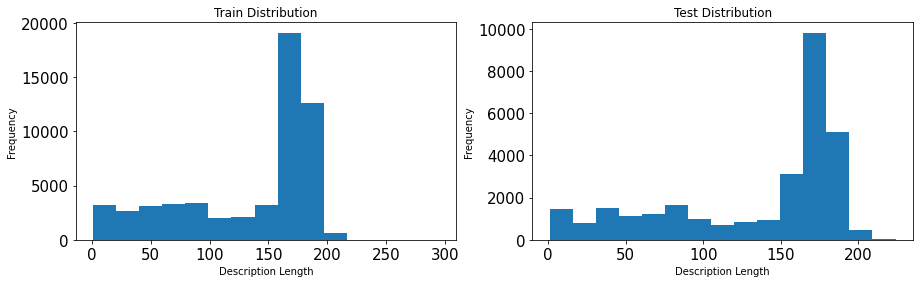

In [18]:
plt.subplots(1, 2, figsize=(15, 4))
plt.subplot(1, 2, 1)
plt.title("Train Distribution")
plt.xlabel("Description Length")
df.deslen.plot.hist(bins=15);
plt.subplot(1, 2, 2)
plt.title("Test Distribution")
plt.xlabel("Description Length")
x_test.deslen.plot.hist(bins=15);

### Add numerical feature-sentiment description

We also expect the sentiment of description will reflect the level of positive the description, although the description is written by the host.

Therefore, we will extract the a numerical variable(sentiment) from the textual feature(description) by using library 'SentimentIntensityAnalyzer'. We will also calculate the correlation and verify the feature importance later in this part. It will give us four scores('neg','neu','pos','compound'). We will use compund score, ranging from -1 to 1.

In [19]:
sia = SentimentIntensityAnalyzer()
sia.polarity_scores("Wow, NLTK is really powerful!")

{'neg': 0.0, 'neu': 0.295, 'pos': 0.705, 'compound': 0.8012}

In [20]:
df["sentiment"] = df.description.apply(lambda description: sia.polarity_scores(description)['compound'])
x_test["sentiment"] = x_test.description.apply(lambda description: sia.polarity_scores(description)['compound'])
df["sentiment"]

0        0.9746
1        0.9861
2        0.0000
3        0.9387
4        0.9863
          ...  
55279    0.8625
55280    0.4019
55281    0.9797
55282    0.9827
55283    0.9920
Name: sentiment, Length: 55284, dtype: float64

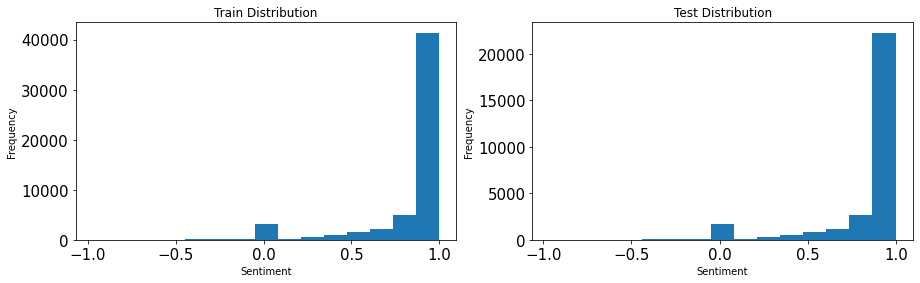

In [21]:
plt.subplots(1, 2, figsize=(15, 4))
plt.subplot(1, 2, 1)
plt.title("Train Distribution")
plt.xlabel("Sentiment")
df.sentiment.plot.hist(bins=15);
plt.subplot(1, 2, 2)
plt.title("Test Distribution")
plt.xlabel("Sentiment")
x_test.sentiment.plot.hist(bins=15);

As we expect, all sentiment scores seem to be positive and most of them are close to 1.

### Deal with null value of numerical variables

At first, we select the numerical features and inspect the number of observations which contain missing value.

And then we will replace the missing value with the media value.

In [22]:
#select all numerical variables
col_info['all_num']= df.select_dtypes(include=['int','float']).columns
col_info['all_num']

Index(['host_id', 'host_total_listings_count', 'latitude', 'longitude',
       'accommodates', 'bathrooms', 'bedrooms', 'beds', 'price',
       'guests_included', 'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'reviews_per_month', 'amenities_num', 'deslen',
       'sentiment'],
      dtype='object')

In [23]:
#exclude price and host_id
col_info['num_cols']= col_info['all_num'].delete([0,8])
col_info['num_cols']

Index(['host_total_listings_count', 'latitude', 'longitude', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'guests_included',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'reviews_per_month', 'amenities_num', 'deslen',
       'sentiment'],
      dtype='object')

In [24]:
# check the missing values
print(df[col_info['num_cols']].isnull().sum() )
print(x_test[col_info['num_cols']].isnull().sum() )

host_total_listings_count        111
latitude                           0
longitude                          0
accommodates                       0
bathrooms                         70
bedrooms                          62
beds                             262
guests_included                    0
review_scores_rating           13415
review_scores_accuracy         13448
review_scores_cleanliness      13442
review_scores_checkin          13483
review_scores_communication    13446
review_scores_location         13480
review_scores_value            13480
reviews_per_month              12380
amenities_num                      0
deslen                             0
sentiment                          0
dtype: int64
host_total_listings_count        65
latitude                          0
longitude                         0
accommodates                      0
bathrooms                        50
bedrooms                         29
beds                            142
guests_included                 

In [25]:
#replace empty cells with median
for col_name in col_info['num_cols']:
    
    num_df = df[col_name]
    
    num_df = num_df.fillna(num_df.median())
    col_values = num_df.values.reshape(-1,1)
    
    df[col_name]=col_values

In [26]:
#replace empty cells with median
for col_name in col_info['num_cols']:
    
    num_df = x_test[col_name]
    
    num_df = num_df.fillna(num_df.median())
    col_values = num_df.values.reshape(-1,1)
    
    x_test[col_name]=col_values

### Numerical variables EDA

Here we inspect the distribution of the numerical featurs. From the plot, we can see there is no obvious outliers in the numerical features.


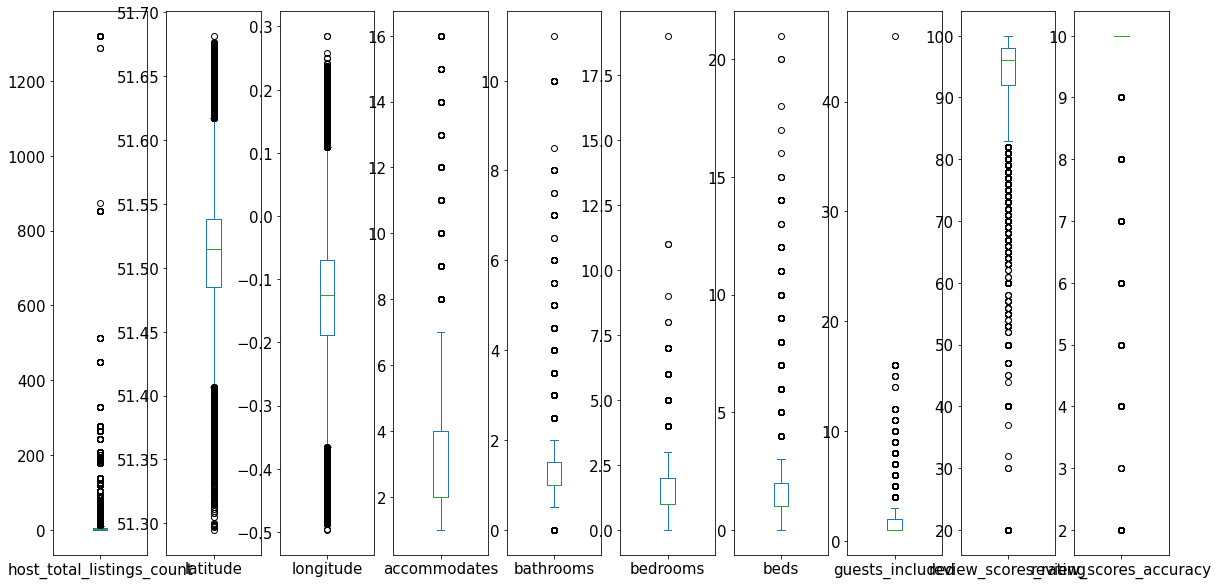

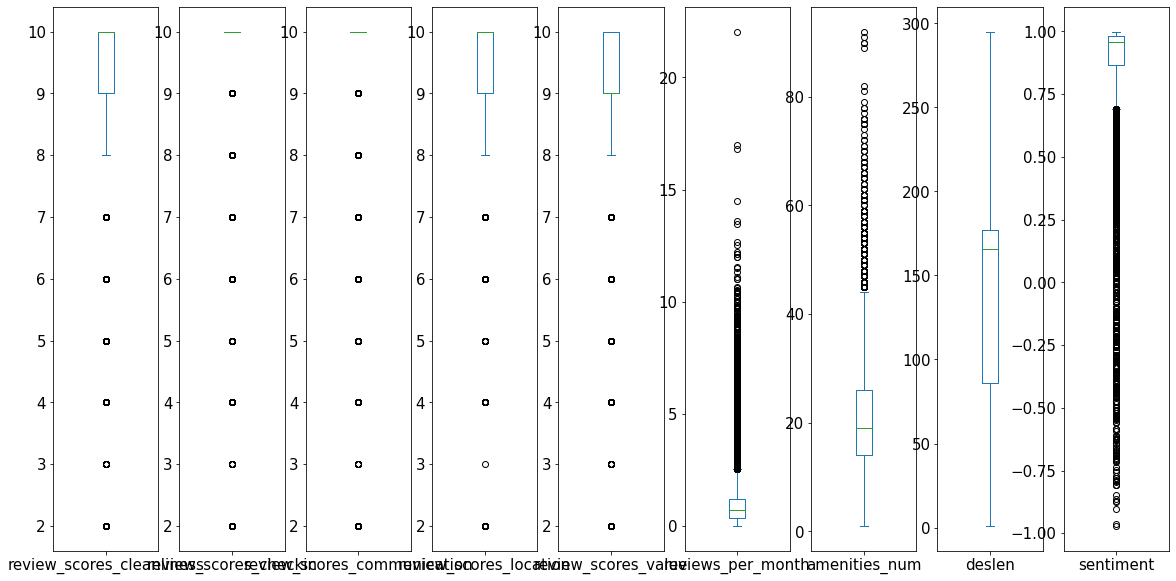

In [28]:
#distribution plot
%matplotlib inline  
plt.rcParams["figure.figsize"] = (20,10)
num_vars = df[col_info['num_cols']]
half = np.ceil(num_vars.shape[1] / 2).astype(int)
num_vars.iloc[:, 0:half].plot(kind = 'box', subplots=True);
num_vars.iloc[:, half:num_vars.shape[1]].plot(kind = 'box', subplots=True);

### Numerical feature selection

If irrelevant features are introduced in the model, the
performance of the model will be harmed. Thus, it
is necessary to select the best features which has higher correlation with the target('price').

We have continous variables and continouse target(price) , and thus Pearson corellation is stuitable in this case. 

The formular is as followed:

$$ \rho = \frac{{}\sum_{i=1}^{n} (x_i - \overline{x})(y_i - \overline{y})}
{\sqrt{\sum_{i=1}^{n} (x_i - \overline{x})^2 \sum_{i=1}^{n} (y_i - \overline{y})^2}} $$

The coefficient produced is bound between -1 and 1. It is recommended to only keep variables with a high correlation. The closer that this coefficient is to 0, the less correlation between the variable and the target.


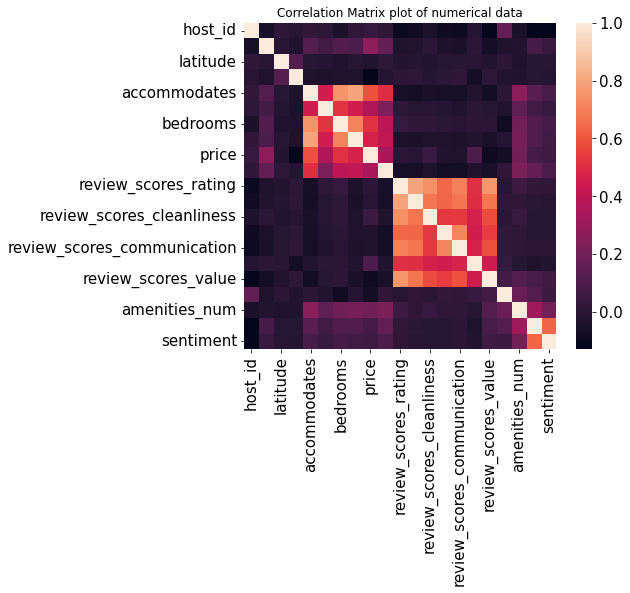

In [29]:
plt.figure(figsize=(7,6))
sns.heatmap(df[col_info['all_num']].corr())
plt.title('Correlation Matrix plot of numerical data')
plt.show()

In [30]:
df[col_info['all_num']].corr()['price'].sort_values(ascending=False)

price                          1.000000
accommodates                   0.588799
bedrooms                       0.511827
beds                           0.469660
bathrooms                      0.361248
guests_included                0.347297
host_total_listings_count      0.269068
amenities_num                  0.199220
review_scores_location         0.096182
deslen                         0.075368
sentiment                      0.059663
review_scores_cleanliness      0.046393
host_id                        0.031447
review_scores_rating           0.002442
review_scores_accuracy        -0.006904
latitude                      -0.024580
review_scores_checkin         -0.031576
review_scores_communication   -0.036661
reviews_per_month             -0.071902
review_scores_value           -0.080512
longitude                     -0.116825
Name: price, dtype: float64

As we can see, 'accomodates' and 'bedrooms' are two most correlated features with target, with higher than 0.5 pearson correlation. It indicates a high correlation with target. It is understandable because that 'accommodates' contains the information about the number of allowed guests and 'bedrooms' is the number of bedrooms in the property.

The number of amenities that we extracted from the amenities has a correlation of 0.199, which is also high. While the length of description and sentiment of description are less important, with correlation 0.075 and 0.060 respectively.

We will select the numerical features with a thresholf of 0.05.

In [31]:
# select numerical columns according to threshold of 0.05
col_info['num_cols']=['accommodates','bedrooms','beds',
                     'bathrooms','guests_included','host_total_listings_count',
                      'amenities_num','longitude','deslen','sentiment',
                      'review_scores_location','review_scores_value','reviews_per_month']

## 2.4 Categorical feature analysis

As to categorical variables, we will deal with the null/missing value, EDA and perform feature selection.At last, the data will be splitted into train and validation dataset. 

### Deal with categorical null value

After selecting the categorical features, we change the data type to category and then deal with the missing value by replacing missing values with the most frequently appeared level.

In [32]:
col_info['cat_cols']=[
    #binary
    'host_is_superhost','host_has_profile_pic','host_identity_verified',
    #multiple levels
    'experiences_offered','room_type','bed_type','cancellation_policy'
]

In [33]:
df[col_info['cat_cols']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55284 entries, 0 to 55283
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   host_is_superhost       55173 non-null  object
 1   host_has_profile_pic    55173 non-null  object
 2   host_identity_verified  55173 non-null  object
 3   experiences_offered     55284 non-null  object
 4   room_type               55284 non-null  object
 5   bed_type                55284 non-null  object
 6   cancellation_policy     55284 non-null  object
dtypes: object(7)
memory usage: 3.0+ MB


In [34]:
#change to category
df[col_info['cat_cols']]=df[col_info['cat_cols']].astype('category') 

In [35]:
print(df[col_info['cat_cols']].isnull().sum())
print(x_test[col_info['cat_cols']].isnull().sum())

host_is_superhost         111
host_has_profile_pic      111
host_identity_verified    111
experiences_offered         0
room_type                   0
bed_type                    0
cancellation_policy         0
dtype: int64
host_is_superhost         65
host_has_profile_pic      65
host_identity_verified    65
experiences_offered        0
room_type                  0
bed_type                   0
cancellation_policy        0
dtype: int64


In [36]:
df.host_is_superhost[df.host_is_superhost.isnull()] = df.host_is_superhost.mode()[0] 
x_test.host_is_superhost[x_test.host_is_superhost.isnull()] = df.host_is_superhost.mode()[0]

df.host_has_profile_pic[df.host_has_profile_pic.isnull()] = df.host_has_profile_pic.mode()[0] 
x_test.host_has_profile_pic[x_test.host_has_profile_pic.isnull()] = df.host_has_profile_pic.mode()[0]

df.host_identity_verified[df.host_identity_verified.isnull()] = df.host_identity_verified.mode()[0] 
x_test.host_identity_verified[x_test.host_identity_verified.isnull()] = df.host_identity_verified.mode()[0]

/var/folders/xx/j02ltht92j17s8dfdgz9ykmc0000gn/T/ipykernel_9486/2295867553.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test.host_is_superhost[x_test.host_is_superhost.isnull()] = df.host_is_superhost.mode()[0]
/var/folders/xx/j02ltht92j17s8dfdgz9ykmc0000gn/T/ipykernel_9486/2295867553.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test.host_has_profile_pic[x_test.host_has_profile_pic.isnull()] = df.host_has_profile_pic.mode()[0]
/var/folders/xx/j02ltht92j17s8dfdgz9ykmc0000gn/T/ipykernel_9486/2295867553.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See 

### Categorical variables EDA

Here we can see the levels of each categorical feature.

In [38]:
print(df['experiences_offered'].value_counts())
print(df['host_is_superhost'].value_counts())
print(df['host_has_profile_pic'].value_counts())
print(df['host_identity_verified'].value_counts())
print(df['room_type'].value_counts())
print(df['bed_type'].value_counts())
print(df['cancellation_policy'].value_counts())

none        54222
business      364
family        300
social        266
romantic      132
Name: experiences_offered, dtype: int64
f    47093
t     8191
Name: host_is_superhost, dtype: int64
t    55124
f      160
Name: host_has_profile_pic, dtype: int64
f    35457
t    19827
Name: host_identity_verified, dtype: int64
Entire home/apt    30504
Private room       23817
Hotel room           539
Shared room          424
Name: room_type, dtype: int64
Real Bed         54864
Pull-out Sofa      239
Futon              116
Couch               38
Airbed              27
Name: bed_type, dtype: int64
strict_14_with_grace_period    24102
flexible                       17094
moderate                       13643
super_strict_60                  230
super_strict_30                  211
strict                             2
luxury_moderate                    1
luxury_super_strict_95             1
Name: cancellation_policy, dtype: int64


This plot shows the distribution of price from levels of the category.


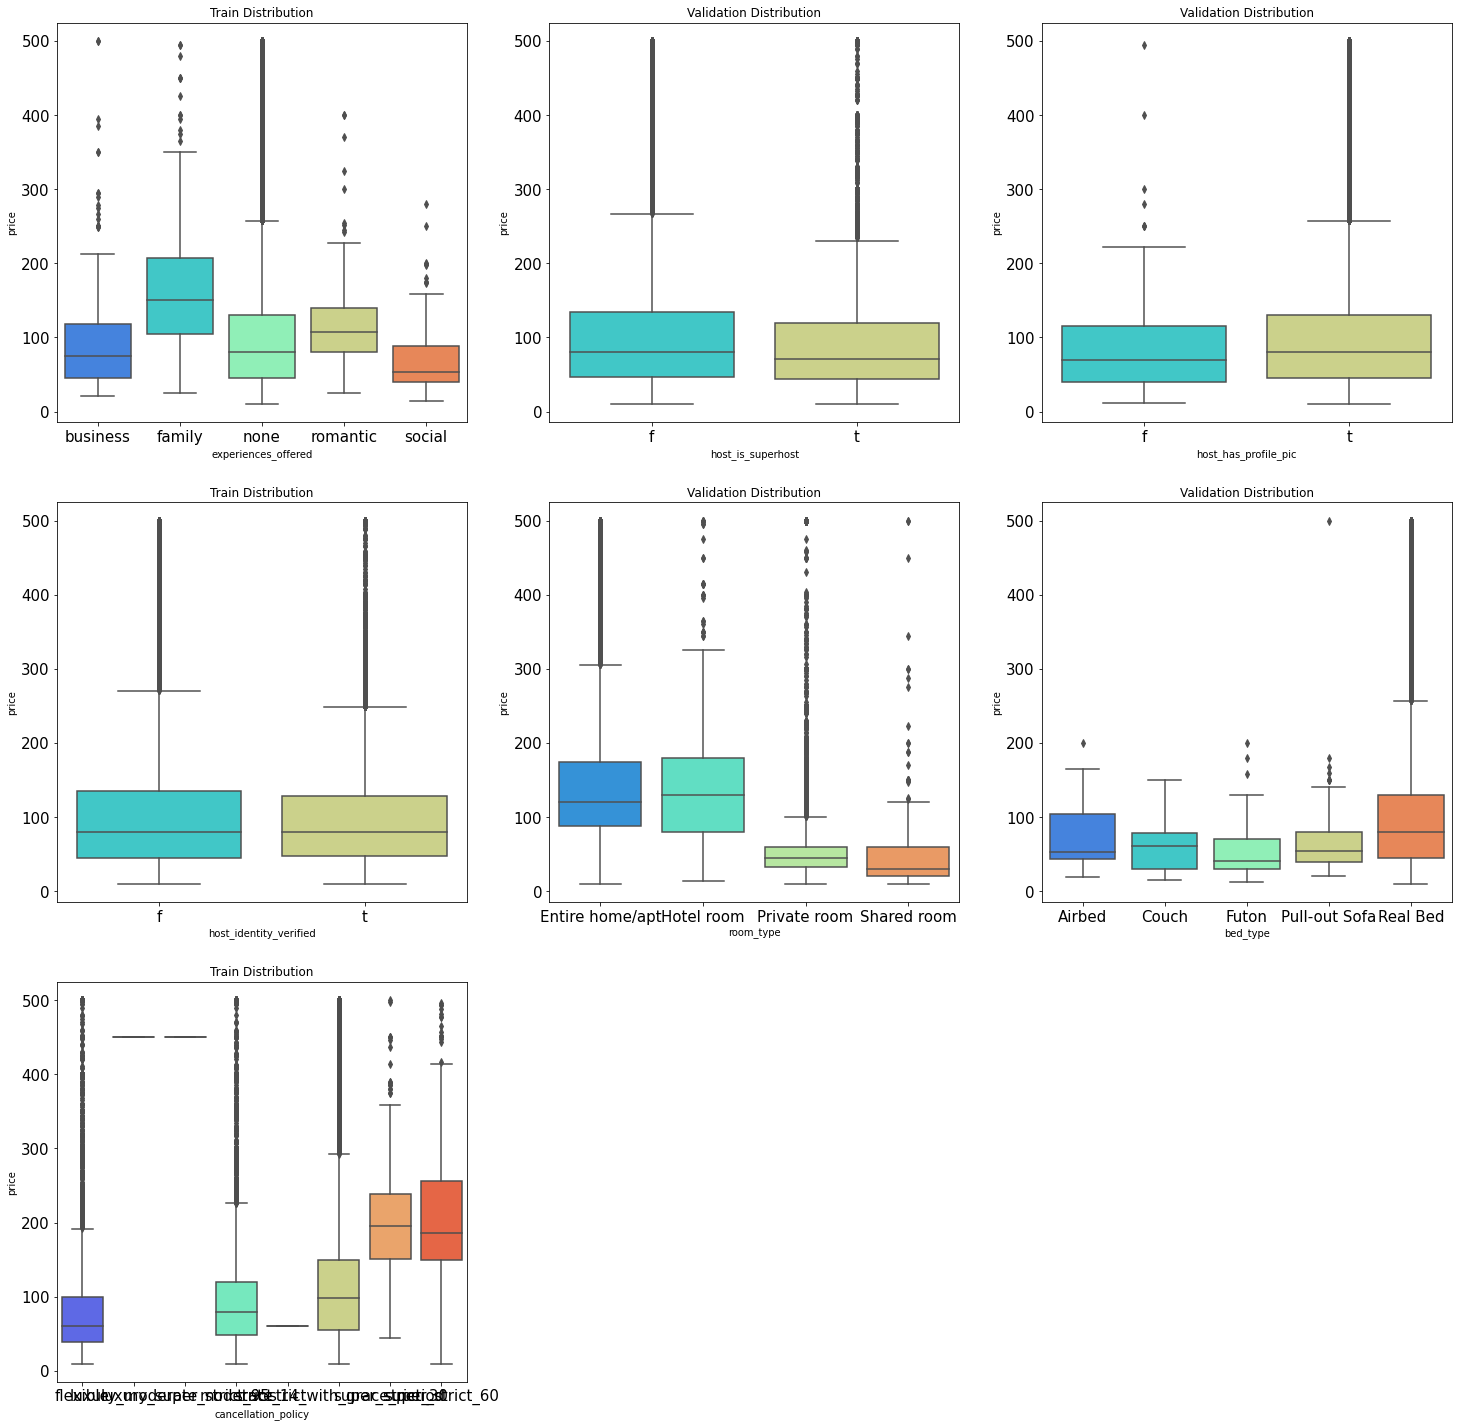

In [39]:
fig = plt.figure(figsize=(25, 25))
plt.subplot(3, 3, 1)
plt.title("Train Distribution")
plt.xlabel("Description Length")
sns.boxplot(x='experiences_offered',y='price',data=df,palette='rainbow');
plt.subplot(3, 3, 2) 
plt.title("Validation Distribution")
plt.xlabel("Description Length")
sns.boxplot(x='host_is_superhost',y='price',data=df,palette='rainbow');
plt.subplot(3, 3, 3) 
plt.title("Validation Distribution")
plt.xlabel("Description Length")
sns.boxplot(x='host_has_profile_pic',y='price',data=df,palette='rainbow');
plt.subplot(3, 3, 4)
plt.title("Train Distribution")
plt.xlabel("Description Length")
sns.boxplot(x='host_identity_verified',y='price',data=df,palette='rainbow');
plt.subplot(3, 3, 5) 
plt.title("Validation Distribution")
plt.xlabel("Description Length")
sns.boxplot(x='room_type',y='price',data=df,palette='rainbow');
plt.subplot(3, 3, 6) 
plt.title("Validation Distribution")
plt.xlabel("Description Length")
sns.boxplot(x='bed_type',y='price',data=df,palette='rainbow');
plt.subplot(3, 3, 7)
plt.title("Train Distribution")
plt.xlabel("Description Length")
sns.boxplot(x='cancellation_policy',y='price',data=df,palette='rainbow');

From the figure, we can see the distribution of price on each level of categorical feature. 

As for features 'experiences_offered', family level has a high mean value while social level has the least mean price. 

As for features 'room_type' and ''cacellation_policy, different levels also have a distinct different price distribution. 

As for 'host_has_profic_pic', 'host_identity_verified' and 'host_is_superhpst', there is not much difference between these levels.

### Categorical feature selection

Here we performed the ANOVA Test to see the correlation among the categorical features with price.

The aim is to check the correlation between a continous target(price) with categorical features. Therefore, Fisher score/ ANOVA is suitable here.

With ANOVA test, we estimate and analyze the difference in the statistical mean of every group of the independent categorical variable.

In the case of the ANOVA test, our Null hypothesis would claim the following: “The statistical mean of all the groups/categories of the variables is the same.”

Considering significance value as 0.05. we say that if the p value is less than 0.05, we assume and claim that there is considerable differences in the mean of the groups formed by each level of the categorical data. That is, we reject the NULL hypothesis.

In [40]:
for col in col_info['cat_cols']:
    model = ols('price' + '~' + col, data = df).fit()
    result_anova = sm.stats.anova_lm(model) # ANOVA Test
    print(result_anova)

                        df        sum_sq        mean_sq        F        PR(>F)
host_is_superhost      1.0  6.324810e+05  632481.030961  90.3397  2.082893e-21
Residual           55282.0  3.870371e+08    7001.141563      NaN           NaN
                           df        sum_sq       mean_sq         F    PR(>F)
host_has_profile_pic      1.0  3.884438e+04  38844.379432  5.539795  0.018592
Residual              55282.0  3.876307e+08   7011.879898       NaN       NaN
                             df        sum_sq        mean_sq          F  \
host_identity_verified      1.0  2.709359e+05  270935.864017  38.662696   
Residual                55282.0  3.873987e+08    7007.681579        NaN   

                              PR(>F)  
host_identity_verified  5.073358e-10  
Residual                         NaN  
                          df        sum_sq        mean_sq          F  \
experiences_offered      4.0  1.706659e+06  426664.656301  61.108448   
Residual             55279.0  3.859629e+08

From the result, all categorical variables has a p-value less than 0.05. Therefore, we will keep all the categorical features.

## 2.5 Splitting data

Here we split the dataframe into train and validation dataset. 

The models will be built based on training dataset and validated on the validation dataset.

In [41]:
y = df['price']
X = df.drop(['price'], axis=1)

X_train, X_val, y_train, y_val = train_test_split(X,y, shuffle=True, random_state= 1)

# 3.Feature Engineering

In this part, we will perform feature engineer in order to prepare the data for feeding into models.

## 3.1 Text feature engineer

After cleaning and preprocessing data, we need to vectorize each text
to numerical sequence, in order to prepare for feeding text into models.

We will introduce two commen techniques here, namely TFIDF and word embedding.

### TF-IDF

Tf-idf stands for term frequency-inverse document frequency. Typically, the tf-idf weight is composed by two terms: the first computes the normalized Term Frequency (TF); the second term is the Inverse Document Frequency (IDF).

TFIDF is easy to compute and commonly use in NLP task. Additionally, it offers an improvement on count-based representations. However, compared to word embedding, TF-IDF cannot help carry semantic meaning.

We implemented TF-IDF by using 'TfidfVectorizer' which is offered by sklearn. It will help us convert a collection of raw documents to a matrix of TF-IDF features.

In [42]:
vectorizer1 = TfidfVectorizer()

vectorizer2 = TfidfVectorizer(
    min_df = 0.02, max_df=0.98
)

We build the vocalbulary based on training dataset and then apply to validation and testing dataset.

Furthermore, we set up some restrictions(min_df and max_df) when build vocabulary of description. With these restriction, it can narrow down the vocalbulary size by filtering out highly appeared or barely appeared words. Because with a large vocalbulary, TF-IDF can suffer from the curse of dimensionality, which brings the overfitting problem.

In [43]:
ame_train= vectorizer1.fit_transform(X_train.amenitiesclean)
ame_val= vectorizer1.transform(X_val.amenitiesclean)
ame_test= vectorizer1.transform(x_test.amenitiesclean)
vocab = vectorizer1.get_feature_names_out()
print('size' +str(len(vocab)))
print(vocab[0:100])
ame_train =ame_train.toarray()
ame_val =ame_val.toarray()
ame_test = ame_test.toarray()

size265
['access' 'accessible' 'aid' 'air' 'alfresco' 'allowed' 'alone' 'amazon'
 'area' 'around' 'baby' 'babysitter' 'backyard' 'baking' 'balcony' 'bar'
 'barbecue' 'basic' 'bath' 'bathroom' 'bathtub' 'bbq' 'beach' 'beachfront'
 'bed' 'bedroom' 'bidet' 'blanket' 'board' 'body' 'book' 'bread'
 'breakfast' 'building' 'buzzer' 'cable' 'carbon' 'card' 'cat' 'ceiling'
 'central' 'chair' 'changing' 'charger' 'check' 'checkout' 'chef' 'child'
 'cleaning' 'clearance' 'coffee' 'comfort' 'computer' 'conditioning'
 'connection' 'console' 'convection' 'cooking' 'cooler' 'corner' 'court'
 'cover' 'crib' 'darkening' 'day' 'detector' 'dining' 'dinnerware'
 'disabled' 'dish' 'dishwasher' 'dog' 'door' 'doorman' 'doorway' 'double'
 'drawer' 'dropoff' 'dryer' 'dvd' 'echo' 'elevator' 'enter' 'entrance'
 'entryway' 'equipment' 'espresso' 'essential' 'ethernet' 'event'
 'exercise' 'extinguisher' 'extra' 'family' 'fan' 'fax' 'fire' 'fireplace'
 'firm' 'first']


In [44]:
des_train= vectorizer2.fit_transform(X_train.desclean)
des_val= vectorizer2.transform(X_val.desclean)
des_test= vectorizer2.transform(x_test.desclean)
vocab = vectorizer2.get_feature_names_out()
print('size' +str(len(vocab)))
print(vocab[0:100])
des_train =des_train.toarray()
des_val =des_val.toarray()
des_test = des_test.toarray()

size581
['able' 'access' 'accessible' 'accommodate' 'accommodation' 'across'
 'additional' 'adventurer' 'air' 'airbnb' 'airport' 'airy' 'along' 'also'
 'always' 'amazing' 'amenity' 'angel' 'another' 'answer' 'anything'
 'apartment' 'appliance' 'area' 'around' 'arrival' 'art' 'ask'
 'attraction' 'available' 'away' 'back' 'balcony' 'bank' 'bar' 'base'
 'basic' 'bath' 'bathroom' 'beautiful' 'beautifully' 'bed' 'bedding'
 'bedroom' 'ben' 'benefit' 'best' 'big' 'block' 'board' 'boast' 'book'
 'booking' 'borough' 'boutique' 'brand' 'breakfast' 'brick' 'bridge'
 'bright' 'british' 'brixton' 'broadway' 'building' 'built' 'bus'
 'business' 'busy' 'cafe' 'call' 'camden' 'canal' 'canary' 'car' 'cat'
 'ceiling' 'center' 'central' 'centre' 'chair' 'charming' 'check'
 'chelsea' 'chest' 'child' 'choice' 'cinema' 'circus' 'city' 'clapham'
 'clean' 'cleaned' 'close' 'clothes' 'club' 'coffee' 'come' 'comfort'
 'comfortable' 'comfortably']


### Vectorization(preparation for word embedding)


In this step, we will prepare the vectorized text in order to feeding into word embedding layer later.


Therefore, we introduce a 'TextVectorization' layer to facilitates the standardization, tokenization and indexing.

At first, sentences are splitted into list of words. We can obtain the size of vocalbulary and max length of the text based on training dataset from this step.

And then, each text is vectorized to numerical sequence with the same length which is equal to the maximum length.



In [45]:
description_vector_train =X_train.desclean
description_vector_train = description_vector_train.to_numpy()

tokenizerdes = Tokenizer(oov_token="<UNK>")
tokenizerdes.fit_on_texts(description_vector_train) #Training tokenizer on train data
train_sequences1 = tokenizerdes.texts_to_sequences(description_vector_train) #Converting train texts to sequences 
max_len1 = np.max([len(seq) for seq in train_sequences1])  
vocab_size1 = len(tokenizerdes.word_index)+1
print(max_len1,vocab_size1)
seq_length1 = max_len1.item()

# Create a vectorization layer
vectorize_layer1 = TextVectorization(
    max_tokens = vocab_size1,
    output_sequence_length = seq_length1
    )

vectorize_layer1.adapt(description_vector_train)
vocab = vectorize_layer1.get_vocabulary()
print(vocab[:10])

description_vector_train = vectorize_layer1(description_vector_train)
print(description_vector_train)

description_vector_val =X_val.desclean
description_vector_val = description_vector_val.to_numpy()
description_vector_val = vectorize_layer1(description_vector_val)

description_vector_test =x_test.desclean
description_vector_test = description_vector_test.to_numpy()
description_vector_test = vectorize_layer1(description_vector_test)

148 27721


2022-09-08 14:58:24.035061: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


['', '[UNK]', 'london', 'room', 'bedroom', 'minute', 'walk', 'flat', 'kitchen', 'station']
tf.Tensor(
[[  41  293   13 ...    0    0    0]
 [ 178 5191  150 ...    0    0    0]
 [ 193   42   42 ...    0    0    0]
 ...
 [ 113  873  264 ...    0    0    0]
 [  23   41    4 ...    0    0    0]
 [  40   56   50 ...    0    0    0]], shape=(41463, 148), dtype=int64)


In [46]:
amenities_vector_train =X_train.amenitiesclean
amenities_vector_train = amenities_vector_train.to_numpy()

tokenizeramenities = Tokenizer(oov_token="<UNK>") 
tokenizeramenities.fit_on_texts(amenities_vector_train) #Training tokenizer on train data
train_sequences1 = tokenizeramenities.texts_to_sequences(amenities_vector_train) #Converting train texts to sequences 
max_len2 = np.max([len(seq) for seq in train_sequences1])
vocab_size2 = len(tokenizeramenities.word_index)+1
print(max_len2,vocab_size2)
seq_length2 = max_len2.item()

# Create a vectorization layer
vectorize_layer4 = TextVectorization(
    max_tokens = vocab_size2,
    output_sequence_length = seq_length2
    )

vectorize_layer4.adapt(amenities_vector_train)
vocab = vectorize_layer4.get_vocabulary()
print(vocab[:10])

amenities_vector_train = vectorize_layer4(amenities_vector_train)
print(amenities_vector_train)

amenities_vector_val =X_val.amenitiesclean
amenitiesn_vector_val = amenities_vector_val.to_numpy()
amenities_vector_val = vectorize_layer4(amenities_vector_val)

amenities_vector_test =x_test.amenitiesclean
amenities_vector_test = amenities_vector_test.to_numpy()
amenities_vector_test = vectorize_layer4(amenities_vector_test)

194 267
['', '[UNK]', 'detector', 'dryer', 'wifi', 'heating', 'essential', 'kitchen', 'friendly', 'smoke']
tf.Tensor(
[[ 4  7 40 ...  0  0  0]
 [ 4 93 95 ...  0  0  0]
 [ 4  7  5 ...  0  0  0]
 ...
 [ 4  7 53 ...  0  0  0]
 [52  4  7 ...  0  0  0]
 [ 4  7 69 ...  0  0  0]], shape=(41463, 194), dtype=int64)


### Pre-trained embedding

We can also use pre-trained embedding that were crafted from big corpora. Glove, which is short for Global Vectors for Word Representation. It's a popular embedding technique based on aggregating global word-word co-occurrence matrix from a corpus (https://nlp.stanford.edu/projects/glove/). We will use the weights later in CNN models.

In [47]:
glove_index = {}
with open('/Users/kelly/Desktop/adams/assignment/Data/' + 'glove.6B.50d.txt', 'r', encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        glove_index[word] = coefs

print('Found %s word vectors.' % len(glove_index))

Found 400000 word vectors.


The function below is referenced to the notebook:https://github.com/Humboldt-WI/adams/blob/master/work-in-progress/sentiment-analysis.ipynb

In [48]:
def get_embedding_matrix(tokenizer, pretrain, vocab_size):
    '''
        Helper function to construct an embedding matrix for 
        the focal corpus based on some pre-trained embeddings.
    '''
    
    dim = 0
    if isinstance(pretrain, KeyedVectors) or isinstance(pretrain, Word2VecKeyedVectors):
        dim = pretrain.vector_size        
    elif isinstance(pretrain, dict):
        dim = next(iter(pretrain.values())).shape[0]  # get embedding of an arbitrary word
    else:
        raise Exception('{} is not supported'.format(type(pretrain)))
    
    emb_mat = np.zeros((vocab_size, dim))
   
    oov_words = []
   
    for word, i in tokenizer.word_index.items():  
        
        try:
            emb_mat[i] = pretrain[word]
        except:
            oov_words.append(word)
    print('Created embedding matrix of shape {}'.format(emb_mat.shape))
    print('Encountered {} out-of-vocabulary words.'.format(len(oov_words)))
    return (emb_mat, oov_words)

In [49]:
amenities_weights, _ = get_embedding_matrix(tokenizeramenities, glove_index, vocab_size2)

Created embedding matrix of shape (267, 50)
Encountered 1 out-of-vocabulary words.


In [50]:
des_weights, _ = get_embedding_matrix(tokenizerdes, glove_index, vocab_size1)

Created embedding matrix of shape (27721, 50)
Encountered 8338 out-of-vocabulary words.


## 3.2 Numerical feature engineer

As we know, different numerical variables have different value ranges. This might cause problems to the prediction results. Therefore, we will perform scaling for the numerical features. After scaling, the values of each numerical feature will distribute in the same and controlled range. 


There are also varias approaches to scale the features.Two major ways could be: standardization and min-max scaling (also known as normalization). Here we will perform standardization using 'StandardScaler'.

After standardization, your feature will now be distributed around a mean feature value of zero with standard deviation equal to one.

$$ X_{new} = \frac{X-\mu}{\sigma} $$


In [51]:
X_train_num =X_train[col_info['num_cols']]
X_val_num =X_val[col_info['num_cols']]
x_test_num =x_test[col_info['num_cols']]

numerical_transformer = StandardScaler()
X_train_numscale = numerical_transformer.fit_transform(X_train_num)
X_train_num =pd.DataFrame(X_train_numscale, index = X_train_num.index,columns= X_train_num.columns)

X_val_numscale =numerical_transformer.transform(X_val_num)
X_val_num = pd.DataFrame(X_val_numscale, index =X_val_num.index,columns= X_val_num.columns)

x_test_numscale =numerical_transformer.transform(x_test_num)
x_test_num = pd.DataFrame(x_test_numscale, index= x_test_num.index,columns= x_test_num.columns)
x_test_num.head()

,accommodates,bedrooms,beds,bathrooms,guests_included,host_total_listings_count,amenities_num,longitude,deslen,sentiment,review_scores_location,review_scores_value,reviews_per_month
0,-0.585607,-0.433922,-0.577669,-0.498677,-0.450236,-0.167966,-0.243826,-0.892449,-1.685450,0.358772,0.473638,0.885234,0.686831
1,-0.585607,-0.433922,-0.577669,-0.498677,-0.450236,-0.055052,-0.580131,-0.748095,0.666982,0.412766,0.473638,0.885234,1.193827
2,-0.585607,-0.433922,-0.577669,2.150589,-0.450236,-0.167966,-0.243826,-0.215490,-1.598963,-0.946279,0.473638,-0.218328,-0.293914
3,-1.102379,-0.433922,-0.577669,0.384412,-0.450236,-0.167966,-0.804334,0.676667,-1.823828,-0.012211,0.473638,-0.218328,-0.293914
4,-0.068836,-0.433922,0.238159,-0.498677,0.332692,-0.150595,-0.355928,-0.618571,0.649685,0.405053,0.473638,0.885234,-0.094440


## 3.3 Categorical feature engineer

As for categorical features, we will get dummy variables from all the level.

It is also important to keep the training dataset, validation dataset and test dataset in the same dimensions.

In [52]:
X_train_dummy = pd.get_dummies(X_train[col_info['cat_cols']], columns = col_info['cat_cols'])
X_val_dummy = pd.get_dummies(X_val[col_info['cat_cols']], columns = col_info['cat_cols'])
x_test_dummy = pd.get_dummies(x_test[col_info['cat_cols']], columns = col_info['cat_cols'])

print(X_val_dummy.shape)
print(X_train_dummy.shape)
print(x_test_dummy.shape)

(13821, 28)
(41463, 28)
(29769, 26)


In [53]:
#ensure the same dimensionality
x_test_dummy['cancellation_policy_luxury_super_strict_95']=0
x_test_dummy['cancellation_policy_luxury_moderate']=0

In [54]:
print(X_val_dummy.shape)
print(X_train_dummy.shape)
print(x_test_dummy.shape)

(13821, 28)
(41463, 28)
(29769, 28)


## 3.4 Final tabular dataframe combination

At this stage, we combined the selected and preprocessed numerical features and categorical features into one dataframe.
 
We will feed the tabular data into the models finally.

In [55]:
X_train_other = pd.concat([X_train_num,X_train_dummy], axis=1)
X_val_other = pd.concat([X_val_num,X_val_dummy], axis=1)
x_test_other = pd.concat([x_test_num,x_test_dummy], axis=1)

In [56]:
X_train_meta=X_train_other.values
X_val_meta=X_val_other.values
x_test_meta=x_test_other.values

In [57]:
X_train_meta.shape

(41463, 41)

# 4.Model Selection

In this section, I will build the models and compare the performance of the models.

I selected models in the range of machine learning and deep learning models. Random forest will act as a representative ensemble models in machine learning. As for deep learning models, feed forward neural network, RNN and CNN will be introduced.

The performance of models will be compared in the dimension of building time, MSE and MAE. The result can be found in the table.

## 4.1 Random forest

Random forest is a representative of ensemble learners and we will compare the performance with other models.

Features:

We will make use of the processsed tabular data and TF-IDF processed textual data together or seperately to build the model. From trying the combinations of features, we will figure out which combination of features perform the best and use the combination of features in deep learning models later.

The following steps will be performed in this part:

1.Building model with tabular features:
1.1 Model tuning1.2 Feature importance interpretation

2.Building model with tabular features+ Text features(TF-IDF)

We compare the performance of random forest with different features from the dimensions of traing time, MSE and MAE.

|Model|Feature| Training time(seconds) | MSE | RMSE|MAE|  
|---|---|---|---|---|---|
|1|Tabular data|26.53|2647.08|51.45|32.07|
|2|Tabular data(fine tuned)|28.05|2571.59|50.71|31.53|
|3|Tabular data + amenities|255.06|2517.15|50.17|30.91|
|4|Tabular data + description|693.73|2477.82|49.78|30.20|
|5|Tabular data + amenities + description|1053.19|2443.64|49.43|29.88|

From the table, we can see that random forest using tabular data have already given us a reasonable result with RMSE 51.45 and MAE 32.07.  The MAE and MSE decrease when we combined the one text data with tabular data, while the training time increase more than 20 times comparing the random forest using tabular data and description with only using tabular data. Therefore, we can see that the amenities text data and description text data all add information to the model. We obtain the random forest with best RMSE(49.74) and MAE(29.88) from combination of tabular data, amenities text data and description text data. We will also introduce the combination of the features into the deep learning models later. But the training time increases extremely, which also indicates the disadvantage of random forest in training speed of textual data.


In order to increase readability, we only keep the code of model 1,2 and 5 in the following. The code of other models can be found in another notebook.

#### Random forest + tabular data input

In [59]:
rf  = RandomForestRegressor(random_state=1)

start_time = time.perf_counter()
rf.fit(X_train_meta,y_train)
end_time = time.perf_counter()
total_time = end_time - start_time


prediction = pd.DataFrame({"Prediction": rf.predict(X_val_meta), "Actual": y_val})

print(f'Training Took {total_time:.2f} seconds')
print(f"MSE: {mean_squared_error(prediction.Actual, prediction.Prediction):.2f}")
print(f"RMSE: {math.sqrt(mean_squared_error(prediction.Actual, prediction.Prediction)):.2f}")
print(f"MAE: {mean_absolute_error(prediction.Actual, prediction.Prediction):.2f}")

Training Took 26.53 seconds
MSE: 2647.08
RMSE: 51.45
MAE: 32.07


##### Model tuning

We tune the randam forest using a grid search method.

The parameters to be tuned are 'n_estimators' and 'max_features'. There are in total 9 candidate models in this process.


In [60]:
#tune rf
rf2 = RandomForestRegressor(random_state=1)

param_grid = {'n_estimators': [200, 150, 100],
             'max_features': [ 0.5, 0.8, 1]}
rf_grid = GridSearchCV(rf2, param_grid, 
                       cv = 3, 
                       scoring = 'neg_mean_squared_error', verbose = 1)

start_time = time.perf_counter()
rf_grid.fit(X_train_meta,y_train)
end_time = time.perf_counter()
total_time = end_time - start_time

print(f'Training Took {total_time:.4f} seconds')
print(rf_grid.best_params_)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
Training Took 362.6826 seconds
{'max_features': 0.5, 'n_estimators': 200}


Then we build the model with tuned parameter to get a better result.

In [61]:
#tuned random forest
rf2  = RandomForestRegressor(n_estimators= 200, max_features=0.5,random_state=1)

start_time = time.perf_counter()
rf2.fit(X_train_meta,y_train)
end_time = time.perf_counter()
total_time = end_time - start_time

prediction = pd.DataFrame({"Prediction": rf2.predict(X_val_meta), "Actual": y_val})

print(f'Training Took {total_time:.2f} seconds')
print(f"MSE: {mean_squared_error(prediction.Actual, prediction.Prediction):.2f}")
print(f"RMSE: {math.sqrt(mean_squared_error(prediction.Actual, prediction.Prediction)):.2f}")
print(f"MAE: {mean_absolute_error(prediction.Actual, prediction.Prediction):.2f}")

Training Took 28.05 seconds
MSE: 2571.59
RMSE: 50.71
MAE: 31.53


##### Feature importance interpretation

There are in total 41 tabular features in the model, so it is necessary to analysis the importance of feature. Here we are using impurity-based importance to illustrate.

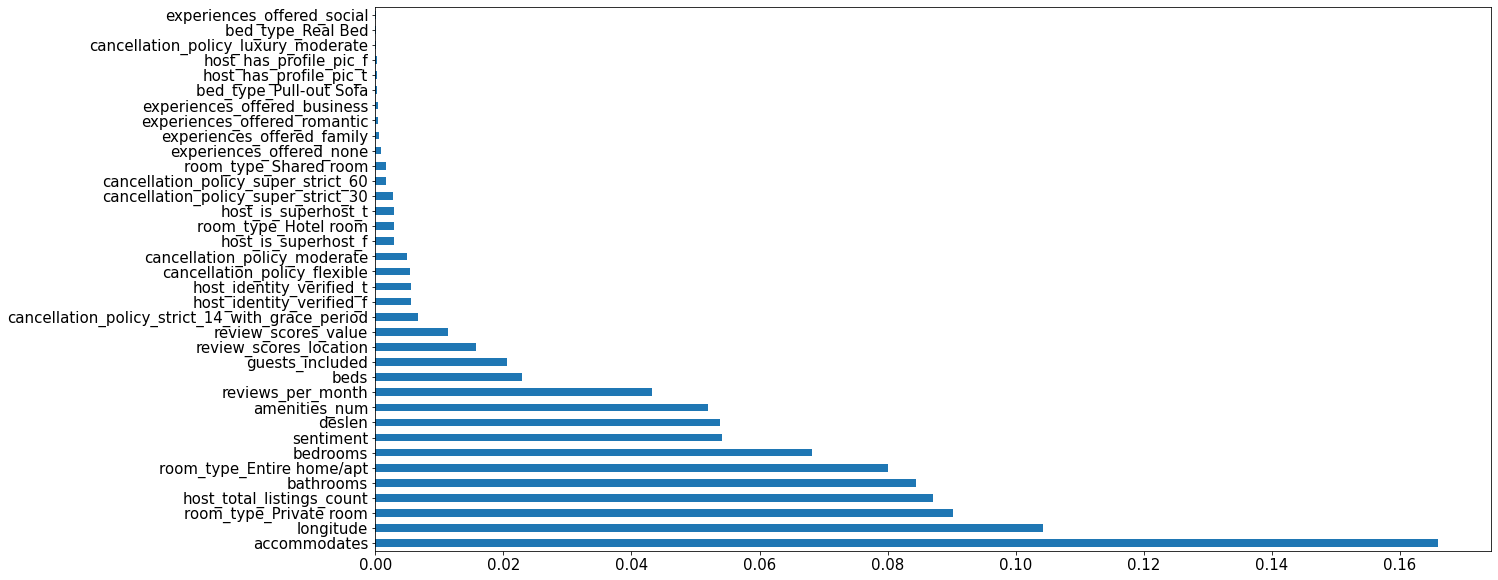

In [62]:
feat_importances_rf = pd.Series(rf2.feature_importances_, index= X_train_other.columns)
feat_importances_rf.nlargest(36).plot(kind='barh');

The score of each feature is normalized to sum to one. From the plot, we can see that accomodates, longitude, room_type_privateroom are top three most important variables as for random forest. However, some variables seem have not much impact on the predictions.

#### Random forest + (tabular input+ amenities text input + description text input)

Here we concate the tabular data with TF-IDF processed amenities and description data into random forest.

In [67]:
X_train_rf =np.concatenate((X_train_meta, ame_train, des_train), axis=1)
X_val_rf = np.concatenate((X_val_meta,ame_val, des_val), axis=1)
X_test_rf =np.concatenate((x_test_meta,ame_test, des_test), axis=1)

In [68]:
rf5  = RandomForestRegressor(n_estimators= 200, max_features=0.5,random_state=1)

start_time = time.perf_counter()
rf5.fit(X_train_rf,y_train)
end_time = time.perf_counter()
total_time = end_time - start_time


prediction = pd.DataFrame({"Prediction": rf5.predict(X_val_rf), "Actual": y_val})

print(f'Training Took {total_time:.2f} seconds')
print(f"MSE: {mean_squared_error(prediction.Actual, prediction.Prediction):.2f}")
print(f"RMSE: {math.sqrt(mean_squared_error(prediction.Actual, prediction.Prediction)):.2f}")
print(f"MAE: {mean_absolute_error(prediction.Actual, prediction.Prediction):.2f}")

Training Took 1053.19 seconds
MSE: 2443.64
RMSE: 49.43
MAE: 29.88


We add the textual information(amenities and description),which add more useful information. Therfore, we have a better result.

## 4.2 Feedforwad NN

We will explore and perform the deep learning models in the following sections. We will start with feedforward NN, in which the information will go in only one direction.

Referring to the excellent discussion and summary on internet, it is said that there is no obvious performance difference from adding hidden layer. And the suggested size of hidden neurons is usually between the size of the input and size of the output layer. As for tuning batch size, reffereing to https://arxiv.org/abs/1804.07612 , it is said that small batch training has been shown to provide improved generalization performance, although the use of large batch size increases the available computational parallelis. The suggesting bactch size from the paper is between 2 and 32. We can use 32 by default.

Therefore, we build a simple feedforward NN concating the tabular data, TF-IDF processed amenities text data and TF-IDF processed description text data. And then put the concate result to a hidden layer in size of 108 hidden neurons. At last, we solve the linear regression problem using a default linere activation with one neoron. 

### TF-IDF + Feedforward NN


In [68]:
nlp_input1 = tf.keras.Input(shape=(ame_train.shape[1],))
nlp_input2 = tf.keras.Input(shape=(des_train.shape[1],))
meta_input = tf.keras.Input(shape=(X_train_meta.shape[1],))

input1 = layers.Dense(32, activation="relu")(nlp_input1)
input2 = layers.Dense(56, activation="relu")(nlp_input2)

concat = concatenate([input1, input2, meta_input]) 
out = layers.Dense(108, activation="relu")(concat)

output= layers.Dense(1, activation='linear', name='Linear')(out) 

model = tf.keras.Model(inputs=[nlp_input1 , nlp_input2, meta_input], outputs=[output])

model.compile(optimizer="adam",
              loss="mse",
              metrics=['mae'])

print(model.summary())

early_stopping_monitor = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=3,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)

start_time = time.perf_counter()
model.fit(x=[ame_train,des_train,X_train_meta],y=y_train, 
          validation_data=([ame_val,des_val,X_val_meta], y_val),
          batch_size=19, epochs=15, verbose=0, 
          callbacks=[early_stopping_monitor])
end_time = time.perf_counter()
total_time = end_time - start_time

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 265)]        0           []                               
                                                                                                  
 input_5 (InputLayer)           [(None, 581)]        0           []                               
                                                                                                  
 dense_3 (Dense)                (None, 32)           8512        ['input_4[0][0]']                
                                                                                                  
 dense_4 (Dense)                (None, 56)           32592       ['input_5[0][0]']                
                                                                                            

In [69]:
preds = pd.DataFrame(model.predict(x=[ame_val,des_val,X_val_meta]), columns=["pred"], index=y_val.index)
preds["actual"] = y_val

print(f'Training Took {total_time:.2f} seconds')
print(f"MSE: {mean_squared_error(preds.pred, preds.actual):.2f}")
print(f"MAE: {mean_absolute_error(preds.pred, preds.actual):.2f}\n") 

Training Took 16.19 seconds
MSE: 2406.42
MAE: 30.10



## 4.3 RNN Architecture

Compared to feedforward NN, RNN models can have signals traveling in both direction. The 'memory' will help with deriving computations from earlier input which will be fed back into the network. Therefore, it will have an advantage especially in dealing with time-series data.

But the disadvantage of RNN is that building RNN models is costly and cannot be parallel computed. 

There are two standard and more complex implementations of RNN, namely GRU and LSTM. They also have an advantage in dealing with vanishing gradient problem by introducing 'gates'.

We will use the pre-trained embeddings which we obtained from section 3.1. As for the model, we choose GRU instead of LSTM considering the constraint of computiong recource and time, because traing GRU will be faster than LSTM.

### Pre-trained embedding+ GRU

In [73]:
nlp_input1 = tf.keras.Input(shape=(seq_length1,))
nlp_input2 = tf.keras.Input(shape=(seq_length2,))
meta_input = tf.keras.Input(shape=(X_train_meta.shape[1],))

emb1 = layers.Embedding(vocab_size1, output_dim=50,
                     embeddings_initializer=Constant(des_weights),
                     input_length=seq_length1, trainable=False)(nlp_input1)
emb2 = layers.Embedding(vocab_size2, output_dim=50,
                     embeddings_initializer=Constant(amenities_weights),
                     input_length=seq_length2, trainable=False)(nlp_input2)

nlp_out1 = GRU(36)(emb1) 
nlp_out2 = GRU(36)(emb2)

concat = concatenate([nlp_out1, nlp_out2, meta_input]) 

out = layers.Dense(36, activation='relu')(concat) 

output = layers.Dense(1, activation='linear', name='Linear')(out) 

model = tf.keras.Model(inputs=[nlp_input1, nlp_input2, meta_input], outputs=[output])

model.compile(optimizer="adam",
              loss="mse",
              metrics=['mae'])
start_time = time.perf_counter()

model.fit(x=[description_vector_train, amenities_vector_train,X_train_meta],
          y=y_train, 
          validation_data=([description_vector_val, amenities_vector_val,X_val_meta], y_val),
          batch_size=32, epochs=15, verbose=0, 
          callbacks=[early_stopping_monitor])

end_time = time.perf_counter()
total_time = end_time - start_time

In [74]:
preds = pd.DataFrame(model.predict(x=[description_vector_val,amenities_vector_val,X_val_meta]), 
                     columns=["pred"], index=y_val.index)
preds["actual"] = y_val

print(f'Training Took {total_time:.2f} seconds')
print(f"MSE: {mean_squared_error(preds.pred, preds.actual):.2f}")
print(f"RMSE: {math.sqrt(mean_squared_error(preds.pred, preds.actual)):.2f}")
print(f"MAE: {mean_absolute_error(preds.pred, preds.actual):.2f}\n")

Training Took 1372.14 seconds
MSE: 2657.07
RMSE: 51.55
MAE: 31.31



## 4.4 CNN Architecture

Compared to RNN, CNN has an advantage in scalability. Therefore, CNN is useful especially in dealing with image input. CNN make use of 'filter ' to achieve convolution. And pooling layers will help with controling overfitting. We will compare the performance of shallow and deep CNN in this section and only keep the code with best performance in order to increase readability. The code of shallow CNN can be found in another notebook.



Compared to the shallow CNN, we add one dropout layer, conv1d and maxpooling layer before the flatten layer for each text input.

|Model| Training time(seconds) | MSE | RMSE|MAE|  
|---|---|---|---|---|
|shallow CNN|235.00|2673.36|51.70|31.98|
|deep CNN|273.32|2655.01|51.53|31.79|

From the table, we can see the performances of deep CNN and shallow CNN are similar. The deep CNN only perform slightly better off in this scenario.

### Word embedding+ deep CNN

In [93]:
nlp_input1 = tf.keras.Input(shape=(seq_length1,))
emb1 = layers.Embedding(input_dim=vocab_size1, output_dim=32, mask_zero=True)(nlp_input1)#padding and stride no better
x = layers.Conv1D(filters = 32, kernel_size = 16, activation = 'relu')(emb1)
x = layers.MaxPooling1D(2)(x)
x = layers.Dropout(0.25,seed=1)(x)
x = layers.Conv1D(filters = 32, kernel_size = 2,activation = 'relu')(x)
x = layers.MaxPooling1D(2)(x)
nlp_out1 = layers.Flatten()(x)

nlp_input2 = tf.keras.Input(shape=(seq_length2,))
emb2 = layers.Embedding(input_dim=vocab_size2, output_dim=16, mask_zero=True)(nlp_input2)
x = layers.Conv1D(filters = 32, kernel_size = 16,  activation = 'relu')(emb2)
x = layers.MaxPooling1D(2)(x)
x = layers.Dropout(0.25,seed=1)(x)
x = layers.Conv1D(filters = 32, kernel_size = 2, activation = 'relu')(x)
x = layers.MaxPooling1D(2)(x)
nlp_out2 = layers.Flatten()(x)


meta_input = tf.keras.Input(shape=(X_train_meta.shape[1],))
meta_out = layers.Dense(24, activation='relu')(meta_input) 

concat = concatenate([nlp_out1,nlp_out2, meta_out]) 

output = layers.Dense(1, activation='linear', name='Linear')(concat) 

model = tf.keras.Model(inputs=[nlp_input1,nlp_input2,meta_input], outputs=[output])

model.compile(optimizer="adam",
              loss="mse",
              metrics=['mae'])

print(model.summary())

start_time = time.perf_counter()

model.fit(x=[description_vector_train, amenities_vector_train,X_train_meta],
          y=y_train, 
          validation_data=([description_vector_val,amenities_vector_val,X_val_meta], y_val),
          batch_size=32, epochs=6, verbose=0, 
          callbacks=[early_stopping_monitor])

end_time = time.perf_counter()
total_time = end_time - start_time

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 148)]        0           []                               
                                                                                                  
 input_11 (InputLayer)          [(None, 194)]        0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 148, 32)      887072      ['input_10[0][0]']               
                                                                                                  
 embedding_3 (Embedding)        (None, 194, 16)      4272        ['input_11[0][0]']               
                                                                                            

In [94]:
preds = pd.DataFrame(model.predict(x=[description_vector_val,amenities_vector_val,X_val_meta]), 
                     columns=["pred"], index=y_val.index)
preds["actual"] = y_val

print(f'Training Took {total_time:.2f} seconds')
print(f"MSE: {mean_squared_error(preds.pred, preds.actual):.2f}")
print(f"RMSE: {math.sqrt(mean_squared_error(preds.pred, preds.actual)):.2f}")
print(f"MAE: {mean_absolute_error(preds.pred, preds.actual):.2f}\n")

Training Took 273.32 seconds
MSE: 2655.01
RMSE: 51.53
MAE: 31.79



## 4.5 Model Summary

| Model |Feature | Text process | Traing time | MSE | RMSE| MAE|  
|---|---|---|---|---|---|---|
|Random Forest|tabular data + description text + amenities text|TF-IDF|1053.19|2443.64|49.43|29.88|
|Feed forward NN|tabular data + description text + amenities text|TF-IDF|16.19|2406.42|49.06|30.01|
|GRU|tabular data + description text + amenities text|Pre-trained Glove embedding|1372.14|2657.07|51.55|31.31|
|CNN|tabular data + description text + amenities text|Embedding|273.32|2655.01|51.53|31.79|




We use tabular data, description and amenities text data as features. The text is processed in three different ways, namely TF-IDF, pre-trained Glove embedding and embedding. The table compared all the models in dimensions of training time, MSE, RMSE and MAE.

As we can see, the random forest and feedforward NN achieve better performance considering MSE, RMSE and MAE. But feedforward NN has an obvious advantage in computing time.

However, although we perform more complex NN, namely GRU and CNN, the performance of GRU and CNN does not increase as we expect. Actually, RNNs are designed to recognize sequential or temporal data and CNNS have an advantage in interpreting visual data or sparse data. Therefore, GRU and CNN did not have an obvious advantage here. At the same time, we used different text process techniques, which also have impact on performance. 

Noticebally, training GRU with pre-trained glove embedding and random forest is time consuming. They have disadvantage in scaling.

# 5.Application to Test Set

We have already processed the test data in 2 and 3 section. As discussed in 4.5, we will apply the best performance model(Feedforward NN) on the test dataset.

In [95]:
nlp_input1 = tf.keras.Input(shape=(ame_train.shape[1],))
nlp_input2 = tf.keras.Input(shape=(des_train.shape[1],))
meta_input = tf.keras.Input(shape=(X_train_meta.shape[1],))

input1 = layers.Dense(32, activation="relu")(nlp_input1)
input2 = layers.Dense(56, activation="relu")(nlp_input2)

concat = concatenate([input1, input2, meta_input]) 
out = layers.Dense(108, activation="relu")(concat)

output= layers.Dense(1, activation='linear', name='Linear')(out) 

model = tf.keras.Model(inputs=[nlp_input1 , nlp_input2, meta_input], outputs=[output])

model.compile(optimizer="adam",
              loss="mse",
              metrics=['mae'])

print(model.summary())

early_stopping_monitor = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=3,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)

start_time = time.perf_counter()
model.fit(x=[ame_train,des_train,X_train_meta],y=y_train, 
          validation_data=([ame_val,des_val,X_val_meta], y_val),
          batch_size=19, epochs=15, verbose=0, 
          callbacks=[early_stopping_monitor])
end_time = time.perf_counter()
total_time = end_time - start_time

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 265)]        0           []                               
                                                                                                  
 input_14 (InputLayer)          [(None, 581)]        0           []                               
                                                                                                  
 dense_8 (Dense)                (None, 32)           8512        ['input_13[0][0]']               
                                                                                                  
 dense_9 (Dense)                (None, 56)           32592       ['input_14[0][0]']               
                                                                                            

In [96]:
y_pred_kaggle = model.predict(x=[ame_test,des_test,x_test_meta])
y_pred_kaggle
x_test['price'] = y_pred_kaggle
submission = x_test[['listing_id', 'price']]


import os  
os.makedirs('/Users/kelly/Desktop/adams/assignment', exist_ok=True)
pd.DataFrame(submission).to_csv('//Users/kelly/Desktop/adams/assignment/output/output.csv', index =False, encoding = 'utf-8-sig') 

# 6.Conclusion

In this assignment, we applied different techniques in Natural Language Processing, including TF-IDF and word embedding. Furthermore, various deep learning models(Feedforward NN, RNN,CNN) and machine learning model(random forest)have been implemented. At last, we also compare the models in dimensions of training time, MSE, RMSE and MAE.

On the other hand, we still have limations and can improve in the future. Tranformer models have not been implemented here. The review data and image of households have not been considered.